# Recurrent Neural Networks


Recurrent Neural Networks are a particular type of neural network where some of the connections can go "backwards"
(there are loops in the structure of the network). Their structure is such they are still differentiable, so we can still
use gradient descend to train them. Their usage is not limited to time series (such as business trends  or video analysis) but also handwriting recognition
and text analysis.
 
In this lab we'll try a variant called LSTM that are much better at 'remembering'long term dependencies (see
`vanishing gradient` in the resources below)

#### External resources:
* [Conincise explanation of RNNs and LSTMs](https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47)
(most of the keras code comes from here)
* [Embedding explanation](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)



In [1]:
# Loading dependencies by running the code block below.
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import backend as K #  solves compatibility errors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("dark")

%matplotlib inline



Using TensorFlow backend.


In [2]:
# loading the dataset
data = pd.read_csv('./data/wikipedia.csv')
# we'll only work on a small part of the dataset, for convenience. Accuracy will be bad
data = data.sample(frac=0.01, random_state=1)
data


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
24915,41e65f43c180838e,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1,1,1,0,1,0
75819,cade9e425d75948e,Agent X2: Basically thanks - with a 'little' m...,0,0,0,0,0,0
53891,8ff87747403ed2e6,Why are my posts being deleted? \r\n\r\nI have...,0,0,0,0,0,0
154159,a95604c7a938abb3,"""\r\n\r\n Controlled Demolitions and Common Se...",0,0,0,0,0,0
13040,2288910537399728,I do not understand your reply. //Blaxthos ( ...,0,0,0,0,0,0
123190,9309014f225e9975,Is this the bizarro world? Removing content is...,0,0,0,0,0,0
33626,59a295885d985ef1,"Well, WP:RS says that articles should use reli...",0,0,0,0,0,0
1150,031c15507901e54a,Oh hear me go someone removes all my pages i g...,0,0,0,0,0,0
48633,820b548b9acc1ee6,can't believe this article was deleted\r\nI'm ...,0,0,0,0,0,0
42817,723d53b4406dc45a,"""\r\n\r\n Comments on GamerGate Workshop page ...",0,0,0,0,0,0


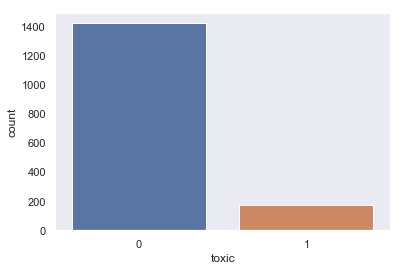

In [3]:
# explore the dataset
sns.countplot(x='toxic', data=data)
plt.show()


## Preprocessing: dictionary and padding
To make it easier to work with text sequences, we are gonna take two preliminary steps:
* convert words into numbers   
* transform arbitrary-size comments into fixed size sequences

Keras has an helpful API called `Tokenizer` that can handle those steps and the hidden
nuisances and headaches for us. The most important decisions to take are:
* how big my dictionary has to be? (too big and the network will be enormous, too small and
the classification will be imprecise and biased)
* which special characters determine a split and which ones not?
* case-sensitive?

Some problems are there, but they don't have a definitive solution, like synonyms ('metalearning' vs 'meta-learning' vs
'meta learning' and so on). In most cases, it depends on the problem. Special characters and case sensitivity could be
meaningless while analyzing an academic paper, but they are probably very important in detecting toxic comments.
('you are wrong' vs 'YOU ARE WRONG!!!!!!1!!)  
    


In [5]:
# create dictionary (using keras' Tokenizer API)
tokenizer = Tokenizer(num_words=2500, lower=True, split=' ')
tokenizer.fit_on_texts(data['comment_text'].values)
print(tokenizer.word_index)


{'the': 1, '\r': 2, 'to': 3, 'and': 4, 'of': 5, 'a': 6, 'i': 7, 'you': 8, 'is': 9, 'that': 10, 'in': 11, 'it': 12, 'for': 13, 'this': 14, 'on': 15, 'not': 16, 'be': 17, 'as': 18, 'are': 19, 'have': 20, 'die': 21, 'with': 22, 'fag': 23, 'your': 24, 'if': 25, 'was': 26, 'or': 27, 'but': 28, 'article': 29, 'an': 30, 'page': 31, 'by': 32, 'from': 33, 'at': 34, 'my': 35, 'do': 36, 'wikipedia': 37, 'so': 38, 'what': 39, 'there': 40, 'about': 41, 'me': 42, 'has': 43, 'talk': 44, 'all': 45, 'will': 46, 'can': 47, 'please': 48, 'no': 49, 'just': 50, 'he': 51, 'would': 52, 'one': 53, 'like': 54, 'they': 55, 'more': 56, 'been': 57, 'should': 58, "don't": 59, 'any': 60, 'his': 61, 'which': 62, 'here': 63, 'other': 64, 'we': 65, 'who': 66, 'edit': 67, 'how': 68, 'because': 69, 'some': 70, 'people': 71, 'also': 72, 'think': 73, 'see': 74, 'out': 75, "i'm": 76, 'articles': 77, 'why': 78, 'when': 79, "it's": 80, 'know': 81, 'use': 82, 'only': 83, 'may': 84, 'these': 85, 'then': 86, 'now': 87, 'am': 88

In [6]:

X = tokenizer.texts_to_sequences(data['comment_text'].values)
X = pad_sequences(X)
X


array([[   0,    0,    0, ...,  198,   24,  175],
       [   0,    0,    0, ...,  247, 1734,    3],
       [   0,    0,    0, ...,  123,  138,   42],
       ...,
       [   0,    0,    0, ...,   52,   17, 1478],
       [   0,    0,    0, ...,  209,  352,  100],
       [   0,    0,    0, ...,   36,    8,   73]])

## Defining the model
Keras allows for many different levels of detail. We'll deal only with the higher level one, where keras builds the entire
recurrent layer and asks only for its hyperparameters.

A different option is to define a single (or multiple) type of recurrent cell and connect them together manually(search
`MinimalRNNCell` [here](https://keras.io/layers/recurrent/).

The lowest level is to define the computation graph directly into [TensorFlow](https://www.tensorflow.org/tutorials/sequences/recurrent),
but requires a very good understanding of both the theory of your RNN and of the TensorFlow architecture. It has the potential
of being very powerful and efficient, but it could end up be buggy and slower than the default implementations.  


In [7]:
embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2500, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(rate=0.2))
model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1250, 128)         320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1250, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 583,602
Trainable params: 583,602
Non-trainable params: 0
_________________________________________________________________
None


## Split the dataset into train and validation


In [8]:
#  convert categorical variables into one-hot encoding
Y = pd.get_dummies(data['toxic']).values
# splitting with sklearn instead of pandas so we get the data in a format ready to be fed to keras 
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.20, random_state = 36)


In [9]:
#Here we train the Network.

results = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=2,
    verbose=2,
)
results.history


Epoch 1/2
 - 99s - loss: 0.4761 - acc: 0.8754
Epoch 2/2
 - 97s - loss: 0.3274 - acc: 0.8895


{'acc': [0.8753918493429321, 0.8894984320413356],
 'loss': [0.4761190794665238, 0.32735704903879137]}